In [1]:
import numpy as np
import glob, os
import xarray as xr
from scipy import fftpack
import time, datetime, calendar, pytz
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import colormath, colormath.color_objects, colormath.color_conversions
from colormath.color_objects import sRGBColor
import urllib
import re
%matplotlib inline

In [2]:
rootdir = '/global/cscratch1/sd/feng045/SAAG/mcs_tracking/3year_test_simulation/'

gpmdir = f'{rootdir}GPM/stats/monthly/'
wrfdir = f'{rootdir}WRF/stats/monthly/'

gpmfiles = sorted(glob.glob(f'{gpmdir}mcs_rainhov_*.nc'))
wrffiles = sorted(glob.glob(f'{wrfdir}mcs_rainhov_*.nc'))

nfiles_gpm = len(gpmfiles)
nfiles_wrf = len(wrffiles)
print(f'Number of files (GPM): {nfiles_gpm}')
print(f'Number of files (WRF): {nfiles_wrf}')

figdir = '/global/cfs/cdirs/m1657/zfeng/SAAG/figures/'
# figdir = '/gpfs/wolf/atm123/proj-shared/zhefeng/SAAG/mcs_tracking/figures/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

Number of files (GPM): 12
Number of files (WRF): 12
/global/cfs/cdirs/m1657/zfeng/SAAG/figures/


In [3]:
def harmonic_phase_amplitude(var, nharm, hr1, binsize=1.0):
    """
    Calculates the harmonic phase and amplitude for the requested number
    of harmonics. The phase indicates the location of the peak closest to
    T=0 for each harmonic along the T-axis--it can be on either side of 0.
    Arguments:
       var   = array to be analyzed, XT ordering assumed.
       nharm = number of harmonics to calculate
       hr1   = hour of the first time in the time series--used to adj. phase to be 0 at 0 hrs
       binsize = size of the hour bin for calculating phase. default=1.0
    Returns:
       amp[nharm] = amplitude of each harmonic
       phs[nharm] = phase of each harmonic, with 0 phase set to hour 0
       pvar[nharm] = percent variance explained
    Created: William.Gustafson@pnnl.gov, 17-Jan-2014
    Last modified: William.Gustafson@pnnl.gov, 22-Jan-2014
    Modified by: Zhe.Feng@pnnl.gov, 10-Jan-2019
    """
    nt = var.shape[-1]
#     w = float(nt) / (2.*np.arccos(-1.))
    w = float(nt) * binsize / (2.*np.arccos(-1.))
    ft = fftpack.fft(var, axis=-1)

    # 0th index returned by fft is the trend, so harmonics start at 1
    ampall = np.abs(ft)[1:] * 2./float(nt)  # need all amplitudes to get total variance
    amp = ampall[0:nharm]
    phs = np.angle(ft)[1:nharm+1]
#     phs = np.angle(ft)[1:nharm+1] * binsize

    totvar = 0.5*np.sum(ampall*ampall)  # total variance
    zeros = np.where(totvar < 1e-12, True, False)  # Need to mask out zero variance values for getting percent values
    totvar_nozeros = np.where(zeros, 1., totvar)
    pvar = np.empty_like(amp)

    for n in range(nharm):
        np1 = n + 1  # adjust by one to get the harmonic number vs. its index
#         phs_offset_max = float(nt)/float(np1)  # max possible phase offset for this harmonic
        phs_offset_max = float(nt) * binsize / float(np1)  # max possible phase offset for this harmonic

        # Have to switch rotation direction of the phase angle to get
        # where first peak occurs. We want it to indicate the angle where
        # the peak occurs. We also do the shift here for the offset due
        # to the first hour not being at 0 (what was sent into this routine).
        phs[n] = phs_offset_max - phs[n] * w / float(np1) + hr1

        # Now, we adjust for a phase that might be a multiple of the given harmonic.
        phs[n] = np.where(phs[n]>phs_offset_max, phs[n]-phs_offset_max, phs[n])
        phs[n] = np.where(phs[n]<0, phs[n] + float(nt)*binsize/float(np1), phs[n])

        # Get percent variance explained by each harmonic.
        pvar[n] = np.where(zeros, 0., 100.*(0.5*amp[n]*amp[n])/totvar_nozeros)
    
    return amp, phs, pvar

In [4]:
def harmonic_phase_amplitude2d(var, nharm, hr1, binsize=1.0):
    """
    Calculates the harmonic phase and amplitude for the requested number
    of harmonics. The phase indicates the location of the peak closest to
    T=0 for each harmonic along the T-axis--it can be on either side of 0.
    Arguments:
       var   = array to be analyzed, YXT ordering assumed.
       nharm = number of harmonics to calculate
       hr1   = hour of the first time in the time series--used to adj. phase to be 0 at 0 hrs
       binsize = size of the hour bin for calculating phase. default=1.0
    Returns:
       amp[nharm] = amplitude of each harmonic
       phs[nharm] = phase of each harmonic, with 0 phase set to hour 0
       pvar[nharm] = percent variance explained
    Created: William.Gustafson@pnnl.gov, 17-Jan-2014
    Last modified: William.Gustafson@pnnl.gov, 22-Jan-2014
    Modified by: Zhe.Feng@pnnl.gov, 10-Jan-2019
    """
    nt = var.shape[-1]
#     w = float(nt) / (2.*np.arccos(-1.))
    w = float(nt) * binsize / (2.*np.arccos(-1.))
    ft = fftpack.fft(var, axis=-1)

    # 0th index returned by fft is the trend, so harmonics start at 1
    ampall = np.abs(ft)[:, 1:] * 2./float(nt)  # need all amplitudes to get total variance
    amp = ampall[:, 0:nharm]
    phs = np.angle(ft)[:, 1:nharm+1]
#     phs = np.angle(ft)[1:nharm+1] * binsize

    totvar = 0.5*np.sum(ampall*ampall, axis=1)  # total variance
    zeros = np.where(totvar < 1e-12, True, False)  # Need to mask out zero variance values for getting percent values
    totvar_nozeros = np.where(zeros, 1., totvar)
    pvar = np.empty_like(amp)

    for n in range(nharm):
        np1 = n + 1  # adjust by one to get the harmonic number vs. its index
#         phs_offset_max = float(nt)/float(np1)  # max possible phase offset for this harmonic
        phs_offset_max = float(nt) * binsize / float(np1)  # max possible phase offset for this harmonic

        # Have to switch rotation direction of the phase angle to get
        # where first peak occurs. We want it to indicate the angle where
        # the peak occurs. We also do the shift here for the offset due
        # to the first hour not being at 0 (what was sent into this routine).
        phs[:,n] = phs_offset_max - phs[:,n] * w / float(np1) + hr1

        # Now, we adjust for a phase that might be a multiple of the given harmonic.
        phs[:,n] = np.where(phs[:,n]>phs_offset_max, phs[:,n]-phs_offset_max, phs[:,n])
        phs[:,n] = np.where(phs[:,n]<0, phs[:,n] + float(nt)*binsize/float(np1), phs[:,n])

        # Get percent variance explained by each harmonic.
        pvar[:,n] = np.where(zeros, 0., 100.*(0.5*amp[:,n]*amp[:,n])/totvar_nozeros)
    
    return amp, phs, pvar

In [5]:
sdate = '2018-12-01'
edate = '2019-03-01'

dsobs = xr.open_mfdataset(gpmfiles, concat_dim='time', combine='nested')
dsobs = dsobs.sel(time=slice(sdate, edate))
lon_obs = dsobs.lon

In [6]:
dswrf = xr.open_mfdataset(wrffiles, concat_dim='time', combine='nested')
dswrf = dswrf.sel(time=slice(sdate, edate))
dswrf['lon'] = dsobs.lon
lon_wrf = dswrf.lon

In [7]:
months_obs = dsobs.time.dt.month
months_wrf = dswrf.time.dt.month
months_obs, months_wrf

(<xarray.DataArray 'month' (time: 2184)>
 array([12, 12, 12, ...,  3,  3,  3])
 Coordinates:
   * time     (time) datetime64[ns] 2018-12-01T00:30:00.000013312 ... 2019-03-...,
 <xarray.DataArray 'month' (time: 2184)>
 array([12, 12, 12, ...,  3,  3,  3])
 Coordinates:
   * time     (time) datetime64[ns] 2018-12-01 ... 2019-03-01T23:00:00)

In [8]:
# startlon = -70.
# endlon = -40.

totpcphovdiur_obs = dsobs.precipitation.groupby('time.hour').mean(dim='time')
mcspcphovdiur_obs = dsobs.mcs_precipitation.groupby('time.hour').mean(dim='time')

lon_obs = dsobs.lon

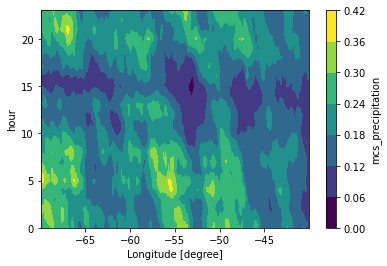

In [9]:
mcspcphovdiur_obs.plot.contourf()

In [10]:
totpcphovdiur_wrf = dswrf.precipitation.groupby('time.hour').mean(dim='time')
mcspcphovdiur_wrf = dswrf.mcs_precipitation.groupby('time.hour').mean(dim='time')

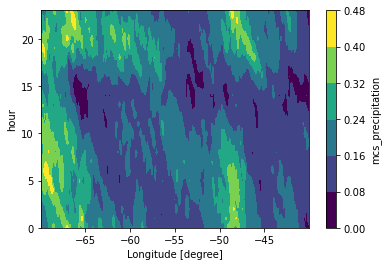

In [11]:
mcspcphovdiur_wrf.plot.contourf()

In [12]:
timezone_shift = -4

hours = np.arange(0, 24.1, 1)
totpcphovdiur_obs_lt = np.roll(totpcphovdiur_obs, timezone_shift, axis=0)
mcspcphovdiur_obs_lt = np.roll(mcspcphovdiur_obs, timezone_shift, axis=0)

# Extend 1 hour at the end of the day and copy the 1st hour values 
# to make a nicer 24 h length
totpcphovdiur_obsE = np.ndarray((25, totpcphovdiur_obs_lt.shape[1]))
totpcphovdiur_obsE[0:24,:] = totpcphovdiur_obs_lt
totpcphovdiur_obsE[24,:] = totpcphovdiur_obs_lt[0,:]

mcspcphovdiur_obsE = np.ndarray((25, mcspcphovdiur_obs_lt.shape[1]))
mcspcphovdiur_obsE[0:24,:] = mcspcphovdiur_obs_lt
mcspcphovdiur_obsE[24,:] = mcspcphovdiur_obs_lt[0,:]

In [13]:
totpcphovdiur_wrf_lt = np.roll(totpcphovdiur_wrf, timezone_shift, axis=0)
mcspcphovdiur_wrf_lt = np.roll(mcspcphovdiur_wrf, timezone_shift, axis=0)

# Extend 1 hour at the end of the day and copy the 1st hour values 
# to make a nicer 24 h length
totpcphovdiur_wrfE = np.ndarray((25, totpcphovdiur_wrf_lt.shape[1]))
totpcphovdiur_wrfE[0:24,:] = totpcphovdiur_wrf_lt
totpcphovdiur_wrfE[24,:] = totpcphovdiur_wrf_lt[0,:]

mcspcphovdiur_wrfE = np.ndarray((25, mcspcphovdiur_wrf_lt.shape[1]))
mcspcphovdiur_wrfE[0:24,:] = mcspcphovdiur_wrf_lt
mcspcphovdiur_wrfE[24,:] = mcspcphovdiur_wrf_lt[0,:]

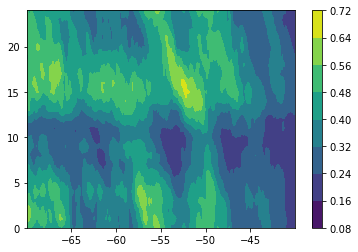

In [14]:
plt.contourf(lon_obs, hours, totpcphovdiur_obsE)
plt.colorbar()

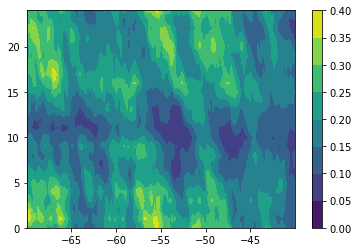

In [15]:
plt.contourf(lon_obs, hours, mcspcphovdiur_obsE)
plt.colorbar()
# mcspcphovdiur_obsE.shape, lon_obs.shape, hours.shape

In [16]:
# MCS precipitation fraction
mcspcpfrac_obsE = (mcspcphovdiur_obsE / totpcphovdiur_obsE)*100
mcspcpfrac_wrfE = (mcspcphovdiur_wrfE / totpcphovdiur_wrfE)*100

In [17]:
nharm = 8
amp_tot_obs, phs_tot_obs, pvar_tot_obs = harmonic_phase_amplitude2d(np.transpose(totpcphovdiur_obs_lt), nharm, 0., binsize=1.)
amp_mcs_obs, phs_mcs_obs, pvar_mcs_obs = harmonic_phase_amplitude2d(np.transpose(mcspcphovdiur_obs_lt), nharm, 0., binsize=1.)

In [18]:
amp_tot_wrf, phs_tot_wrf, pvar_tot_wrf = harmonic_phase_amplitude2d(np.transpose(totpcphovdiur_wrf_lt), nharm, 0., binsize=1.)
amp_mcs_wrf, phs_mcs_wrf, pvar_mcs_wrf = harmonic_phase_amplitude2d(np.transpose(mcspcphovdiur_wrf_lt), nharm, 0., binsize=1.)

In [19]:
amp_mcsfrac_obs, phs_mcsfrac_obs, pvar_mcsfrac_obs = harmonic_phase_amplitude2d(np.transpose(mcspcpfrac_obsE), nharm, 0., binsize=1.)
amp_mcsfrac_wrf, phs_mcsfrac_wrf, pvar_mcsfrac_wrf = harmonic_phase_amplitude2d(np.transpose(mcspcpfrac_wrfE), nharm, 0., binsize=1.)

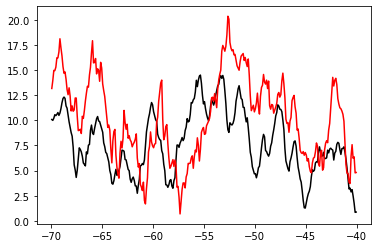

In [20]:
plt.plot(lon_obs, amp_mcsfrac_obs[:,0], 'k', label='OBS')
plt.plot(lon_wrf, amp_mcsfrac_wrf[:,0], 'r', label='WRF')

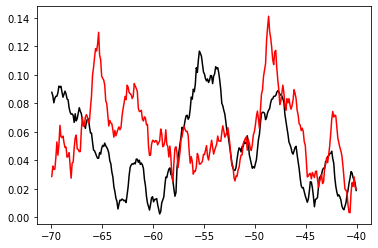

In [21]:
plt.plot(lon_obs, amp_mcs_obs[:,0], 'k', label='OBS')
plt.plot(lon_wrf, amp_mcs_wrf[:,0], 'r', label='WRF')

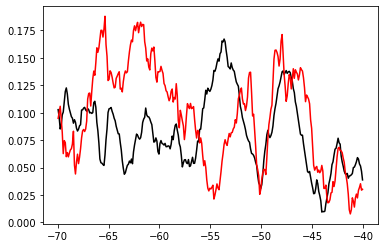

In [22]:
plt.plot(lon_obs, amp_tot_obs[:,0], 'k', label='OBS')
plt.plot(lon_wrf, amp_tot_wrf[:,0], 'r', label='WRF')

In [23]:
color_obj_dict = {'sRGB':colormath.color_objects.sRGBColor,
                  'HSV':colormath.color_objects.HSVColor,
                  'Lab':colormath.color_objects.LabColor,
                  'LCHuv':colormath.color_objects.LCHuvColor,
                  'LCHab':colormath.color_objects.LCHabColor,
                  'XYZ':colormath.color_objects.XYZColor}

def __rgb_to_array(rgb_color):
    r = np.minimum(1, round(rgb_color.rgb_r*10000)/10000)
    g = np.minimum(1, round(rgb_color.rgb_g*10000)/10000)
    b = np.minimum(1, round(rgb_color.rgb_b*10000)/10000)
    return r,g,b


def create_palette(start_rgb, end_rgb, n, colorspace):
    # convert start and end to a point in the given colorspace
    start = colormath.color_conversions.convert_color(start_rgb, colorspace).get_value_tuple()
    end = colormath.color_conversions.convert_color(end_rgb, colorspace).get_value_tuple()

    # create a set of n points along start to end
    points = list(zip(*[np.linspace(start[i], end[i], n) for i in range(3)]))

    # create a color for each point and convert back to rgb
    rgb_colors = [colormath.color_conversions.convert_color(colorspace(*point), sRGBColor) for point in points]

    # finally convert rgb colors back to hex
    return [__rgb_to_array(color) for color in  rgb_colors]


def __retrive_NCL_webcontent(cmapname):
    target_url = 'https://www.ncl.ucar.edu/Document/Graphics/ColorTables/Files/%s.rgb' % cmapname
    request = urllib.request.urlopen(target_url)
    return request


def __collect_discrete_NCL_cmap(cmapname):
    rawdata = __retrive_NCL_webcontent(cmapname)
    
    cmap_color_list = list()
    
    color_section_sig = 0
    
    for line in rawdata:
        
        line_decode = line.decode('utf-8')
        info = re.split('\s+', line_decode.replace('\n','').replace('^\s+',''))

        if color_section_sig==1:
            if info[0]=='' and len(info)>=3:
                if np.maximum(np.maximum(float(info[1]), float(info[2])), float(info[3]))>1:
                    cmap_color_list.append((float(info[1])/255, float(info[2])/255, float(info[3])/255))
                else:
                    cmap_color_list.append((float(info[1]), float(info[2]), float(info[3])))
            if len(info)==3:
                if ';' in info[0] or '#' in info[0]:
                    whatisthis = 's'
                else:
                    if np.maximum(np.maximum(float(info[0]), float(info[1])), float(info[2]))>1:
                        cmap_color_list.append((float(info[0])/255, float(info[1])/255, float(info[2])/255))
                    else:
                        cmap_color_list.append((float(info[0]), float(info[1]), float(info[2])))
        
        if 'ncolors' in str(info[0]):
            color_section_sig = 1  # meaning now we are at color lines (or "r g b" line)

    return cmap_color_list


def __cmap_refinement(raw_cmap_rgb, n_interpolate=10, workspace=color_obj_dict['sRGB']):
    # workspace:  choose which color space the refinement is conducted.
    #             refer to https://stackoverflow.com/questions/55032648/given-a-start-color-and-a-middle-color-how-to-get-the-remaining-colors-python

    n_in = len(raw_cmap_rgb)

    new_array = list()

    for i in np.arange(n_in-1):
        out_colors = create_palette(sRGBColor(*raw_cmap_rgb[i], is_upscaled=False), sRGBColor(*raw_cmap_rgb[i+1], is_upscaled=False), n_interpolate+1, workspace)
        for j in np.arange(len(out_colors)-1):
            new_array.append(out_colors[j])

    return new_array


def generate_NCL_cmap(cmapname, cont_opt=False, cont_param_n=10, cont_param_ws='sRGB',
                      white_first=False, white_ext=False, reverse_cmap=False):
    # description:
    #     cmapname:      taken as shown on the NCL website
    #     cont_opt:      to convert the discreate colormap to continuous colormap
    #     cont_param_n:  how many "intermediate" colors to be inserted to the nearby discreate colors
    #     cont_param_ws: color space to conduct interploation. Default to "sRGB", which should work for most cases
    #     white_first:   whether to set the first color as white. May be useful if the minimum does not mean anything
    #     white_ext:     whether to add this above white as an extended color (when set to True), or just replace the first color (when set to False).
    #     reverse_cmap:  similar to "_r" in colormap.
    # note:  reverse_cmap is applied first, then white_first option.

    cmap_discrete_raw = __collect_discrete_NCL_cmap(cmapname)

    if reverse_cmap==True:
        cmap_discrete_raw.reverse()

    if white_first==True:
        if white_ext==True:
            cmap_discrete = list()
            cmap_discrete.append((1,1,1))
            for i in np.arange(len(cmap_discrete_raw)):
                cmap_discrete.append(cmap_discrete_raw[int(i)])
        else:
            cmap_discrete = cmap_discrete_raw.copy()
        cmap_discrete[0] = (1,1,1)
    else:
        cmap_discrete = cmap_discrete_raw

    if cont_opt==False:
        out_cmap = cmap_discrete

    if cont_opt==True:
        out_cmap = __cmap_refinement(cmap_discrete, n_interpolate=cont_param_n, workspace=color_obj_dict[cont_param_ws])

    return mpl.colors.ListedColormap(out_cmap)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """ Truncate colormap.
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

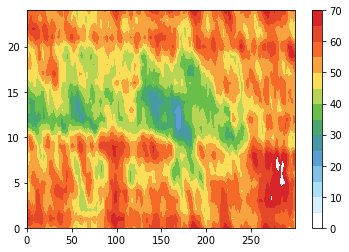

In [24]:
cmap = generate_NCL_cmap('WhiteBlueGreenYellowRed', cont_opt=False, cont_param_n=0, cont_param_ws='sRGB', white_first=True, white_ext=True)
cmap = truncate_colormap(cmap, 0.0, 0.85)
levels = np.arange(0, 71, 5)
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
plt.contourf(mcspcpfrac_obsE, levels=levels, norm=norm, cmap=cmap)
plt.colorbar()

In [25]:
def plot_hov_amp(lonarr, time, dataarr, amparr, ampmax, amplabel, ampcolor, levels, cmap, titles, cblabel, gpcolor,figname):

    mpl.rcParams['font.size'] = 14
    mpl.rcParams['font.weight'] = 'regular'
    mpl.rcParams['font.family'] = 'Helvetica'

    fig = plt.figure(figsize=[16,12], dpi=100)

    # timeval = np.arange(0, 24.1, 6)
    # timename = ('12', '18', '24', '06', '12')
    xlim = (-70, -40)
    xlabels = ['','','','','Longitude','Longitude']
    ylabels = ['Local Time (hour)','','Local Time (hour)','','Local Time (hour)','']
    ylabels2 = ['',amplabel,'',amplabel,'',amplabel]
#     ampcolor = 'tomato'

    gs = gridspec.GridSpec(3,3, height_ratios=[1,1,1], width_ratios=[0.8,0.8,0.03])
    gs.update(left=0.1, right=0.95, bottom=0.1, top=0.9, wspace=0.3, hspace=0.25)

    # Loop over each panel
    panels = [0,1,3,4,6,7]
    for i, pp in enumerate(panels):
        pp = panels[i]
        ax = plt.subplot(gs[pp])
        cs = ax.contourf(lonarr[i], time, dataarr[i], levels[i], cmap=cmap[i], extend='both')
        ax.plot(xlim, (12,12), 'k--')
        # ax.set_yticks(timeval)
        # ax.set_yticklabels(timename)
        ax.set_xlabel(xlabels[i], fontweight='regular')
        ax.set_ylabel(ylabels[i], fontweight='regular')
        ax.set_title(titles[i], loc='left', fontweight='regular')
        ax.set_xlim(xlim)
        # Plot colorbar
        if ((pp == 1) | (pp == 4) | (pp == 7)):
            cax1 = plt.subplot(gs[pp+1])
            cb1 = plt.colorbar(cs, cax=cax1, label=cblabel[pp], orientation='vertical')
        
        ax2 = ax.twinx()
        p2 = ax2.plot(lonarr[i], amparr[i], color=ampcolor[i], lw=2)
        ax2.yaxis.label.set_color(ampcolor[i])
        ax2.set_ylabel(ylabels2[i])
        tkw = dict(size=5, width=1.5)
        ax2.tick_params(axis='y', colors=ampcolor[i], **tkw)
        ax2.set_ylim(0, ampmax[i])

        # Draw an arrow to show the direction of time increase
        if (pp == 0) | (pp == 3) | (pp == 6):
            ax.annotate('', xy=(-0.15, 1), xycoords='axes fraction', xytext=(-0.15, 0), 
                        arrowprops=dict(arrowstyle="->", facecolor='k', lw=3))
        # # Annotate Foothill
        # ax.annotate('Foothill', xy=(-104, 5), xycoords='data', xytext=(-100, 1), color=gpcolor[i], 
        #             horizontalalignment='left', verticalalignment='bottom', fontsize=15, 
        #             arrowprops=dict(arrowstyle="->", color=gpcolor[i], lw=2))
        # Annotate Great Plains
#         gpcolor = 'white'
        # ax.axvline(x=-102, color=gpcolor[i], ls=':', lw=1.5)
        # ax.axvline(x=-90, color=gpcolor[i], ls=':', lw=1.5)
        # ax.text(-96, 21, 'Great Plains', color=gpcolor[i], fontsize=15, ha='center', clip_on=True)
        
#      # Plot colorbars
#     for row in range(0,3):
#         cax1 = plt.subplot(gs[row,3])
#         cb1 = plt.colorbar(cs, cax=cax1, label=cblabel, orientation='vertical')

    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

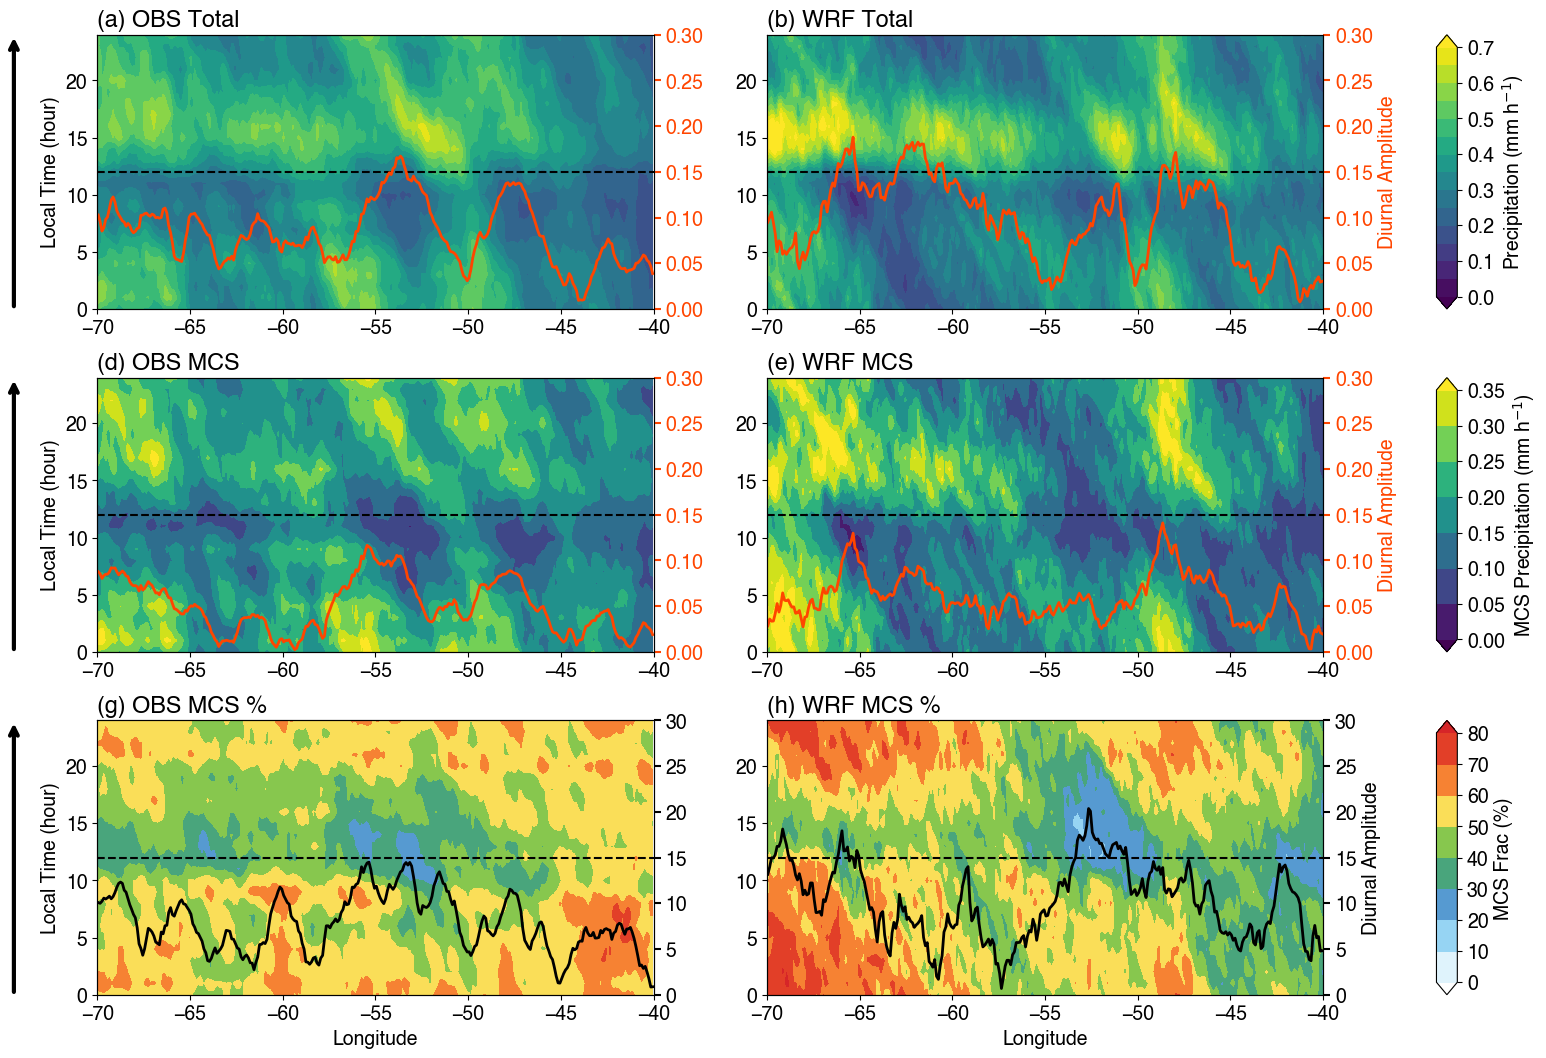

In [27]:
hours = np.arange(0, 24.1, 1)
lonarr = [lon_obs, lon_wrf, lon_obs, lon_wrf, lon_obs, lon_wrf]
dataarr = [totpcphovdiur_obsE, totpcphovdiur_wrfE, 
           mcspcphovdiur_obsE, mcspcphovdiur_wrfE, 
           mcspcpfrac_obsE, mcspcpfrac_wrfE,]
amparr = [amp_tot_obs[:,0], amp_tot_wrf[:,0], 
          amp_mcs_obs[:,0], amp_mcs_wrf[:,0],  
          amp_mcsfrac_obs[:,0], amp_mcsfrac_wrf[:,0],]
ampmax = [0.3, 0.3, 0.3, 0.3, 30, 30]
levelstot = np.arange(0, 0.701, 0.05)
levelsmcs = np.arange(0, 0.351, 0.05)
levelsfrac = np.arange(0, 80.1, 10)
levelsarr = [levelstot, levelstot, levelsmcs, levelsmcs, levelsfrac, levelsfrac]
amplabel = 'Diurnal Amplitude'
# ampcolor = ['tomato','tomato','tomato','tomato','tomato','tomato','blue','blue','blue']
ampcolor = ['orangered','orangered','orangered','orangered','k','k']
cmapfrac = generate_NCL_cmap('WhiteBlueGreenYellowRed', cont_opt=False, cont_param_n=0, cont_param_ws='sRGB', white_first=True, white_ext=True)
cmapfrac = truncate_colormap(cmapfrac, 0.0, 0.85)
cmaparr = ['viridis','viridis','viridis','viridis',cmapfrac,cmapfrac]
cblabel = ['Precipitation (mm h$^{-1}$)','Precipitation (mm h$^{-1}$)','Precipitation (mm h$^{-1}$)',
           'MCS Precipitation (mm h$^{-1}$)','MCS Precipitation (mm h$^{-1}$)','MCS Precipitation (mm h$^{-1}$)',
           'MCS Frac (%)','MCS Frac (%)','MCS Frac (%)',]
titles = ['(a) OBS Total','(b) WRF Total',
          '(d) OBS MCS','(e) WRF MCS',
          '(g) OBS MCS %','(h) WRF MCS %',]
gpcolor = ['white','white','white','white','white','white','k','k','k']
# gpcolor = ['k','k','k','k','k','k','k','k','k']
figname = f'{figdir}imerg_wrf_tot_mcs_rainhov_diurnal_amazon.png'

fig = plot_hov_amp(lonarr, hours, dataarr, amparr, ampmax, amplabel, ampcolor, levelsarr, cmaparr, titles, cblabel, gpcolor, figname)